In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import os
from pathlib import Path

import pandas as pd
from fastai.vision.all import *

# Create the path to save submission files
SUBMISSION_PATH = Path("submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)

In [ ]:
DATA_PATH = Path('/storage/geolifeclef-2022/')

In [ ]:
#exports

def load_train_data(data_path):
    df_obs_fr = pd.read_csv(data_path / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
    df_obs_us = pd.read_csv(data_path / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")
    return pd.concat((df_obs_fr, df_obs_us))
    
def load_test_data(data_path):
    df_obs_fr_test = pd.read_csv(data_path / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
    df_obs_us_test = pd.read_csv(data_path / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

    return pd.concat((df_obs_fr_test, df_obs_us_test))



In [ ]:
df_obs = load_train_data(DATA_PATH)

In [ ]:
df_obs.head()

,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [ ]:
#exports

def rgb_patch_path(observation_id, patches_path=DATA_PATH):
    """Gets the rgb file path associated to an observation id

    Parameters
    ----------
    observation_id : integer
        Identifier of the observation.
    patches_path : string / pathlib.Path
        Path to the folder containing all the patches.

    Returns
    -------
    patch_path : Path
        Returns the path to the rgb patch
    """
    observation_id = str(observation_id)

    region_id = observation_id[0]
    if region_id == "1":
        region = "patches-fr"
    elif region_id == "2":
        region = "patches-us"
    else:
        raise ValueError(
            "Incorrect 'observation_id' {}, can not extract region id from it".format(
                observation_id
            )
        )

    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(patches_path) / region / subfolder1 / subfolder2 / observation_id

    patches = []

    rgb_filename = filename.with_name(filename.stem + "_rgb.jpg")
    return rgb_filename

def near_ir_patch_path(observation_id, patches_path=DATA_PATH):
    """Loads the rgb patch data associated to an observation id

    Parameters
    ----------
    observation_id : integer
        Identifier of the observation.
    patches_path : string / pathlib.Path
        Path to the folder containing all the patches.

    Returns
    -------
    patch_path : Path
        Returns the path to the rgb patch
    """
    observation_id = str(observation_id)

    region_id = observation_id[0]
    if region_id == "1":
        region = "patches-fr"
    elif region_id == "2":
        region = "patches-us"
    else:
        raise ValueError(
            "Incorrect 'observation_id' {}, can not extract region id from it".format(
                observation_id
            )
        )

    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(patches_path) / region / subfolder1 / subfolder2 / observation_id

    near_ir_filename = filename.with_name(filename.stem + "_near_ir.jpg")
    return near_ir_filename


In [ ]:
#exports

def get_rgb_x(r): return rgb_patch_path(r.name)
def get_y(r): return r['species_id']


def splitter(df):
    train = list(df.index.get_indexer_for((df[df.subset == 'train'].index)))
    valid = list(df.index.get_indexer_for((df[df.subset == 'val'].index)))
    return train,valid

In [ ]:
# exports
def clean_obs_data(df):
    df = df.drop(10284349)
    
    df_train = df[df.subset == 'train']
    sp_ids = df_train.species_id.unique()
    df_val = df[(df.subset == 'val') & df.species_id.isin(sp_ids)]
    
    return pd.concat([df_train, df_val])


In [ ]:
df_obs = clean_obs_data(df_obs)

In [ ]:
df_obs.head()

,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [ ]:
#export
def build_learner(df, resnet=resnet34, bs=64):
    
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_x=get_rgb_x, get_y=get_y,
                       splitter=splitter)
    dblock = dblock.new(batch_tfms=[Dihedral(), Brightness(), Contrast()])
    dls = dblock.dataloaders(df, bs=bs)
    
    top_30_accuracy = partial(top_k_accuracy, k=30, axis=-1)
    learn = cnn_learner(dls, resnet, metrics=top_30_accuracy,
                        cbs=[EarlyStoppingCallback(patience=1), SaveModelCallback(with_opt=True)])
    
    return learn

In [ ]:
learner = build_learner(df_obs)

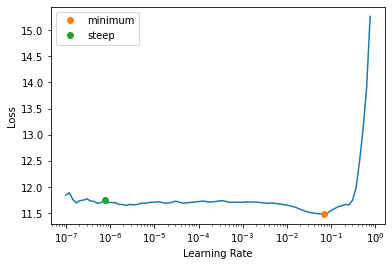

In [ ]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum, steep))